### **We use the prtrained model for glacier mapping**


In [1]:
import torch
import numpy as np
import rasterio as rio
from model import unet
from notebooks import config
from utils.imgShow import imsShow
from utils.img2patch import img2patch


In [2]:
print(len(config.paths_scene_val))
id = np.random.randint(0, len(config.paths_scene_val))
print(id)

17
6


In [3]:
patch_size = 1024
path_scene = config.paths_scene_val[id]
path_dem = config.paths_dem_val[id]
path_truth = config.paths_truth_val[id]
scene_id = path_truth.split('/')[-1].split('.')[0]
print('scene id:', scene_id)



scene id: l7_scene_12


In [4]:
## load trained model
path_trained_model = 'model/trained/patch_' + str(patch_size) + '/unet_weights.pth'
model = unet(num_bands=7)
model.load_state_dict(torch.load(path_trained_model, weights_only=True))
model.eval();  ##  


In [5]:
with rio.open(path_truth) as truth_rio:
    truth_arr = truth_rio.read(1)  # (H,W)
    profile_truth = truth_rio.profile
with rio.open(path_scene) as scene_rio, rio.open(path_dem) as dem_rio:
    scene_dem_arr = np.concatenate([scene_rio.read(), dem_rio.read()], axis=0)
    scene_dem_arr = scene_dem_arr.transpose((1, 2, 0))  # (H,W,C)
scene_dem_arr.shape


(1912, 1879, 7)

In [6]:
### image to patches
imgPat_obj = img2patch(img=scene_dem_arr, patch_size=patch_size, edge_overlay = 40)
patch_arr_list = imgPat_obj.toPatch()
# 1. channel first, and 2. numpy array to torch tensor
patch_list = [torch.from_numpy(patch.transpose(2,0,1)).float() for patch in patch_arr_list]  
with torch.no_grad():  ## save 
    presult_list = [model(patch[np.newaxis, :]) for patch in patch_list]
## 1.channel last, and 2.torch tensor to numpy array
presult_arr_list = [np.squeeze(patch.detach().numpy().transpose(0,2,3,1), axis = 0) 
                                for patch in presult_list ]       


In [7]:
## patch to image
gla_pred_prob = imgPat_obj.toImage(presult_arr_list)
gla_pred_cla = np.where(gla_pred_prob>0.5, 1, 0)
gla_pred_cla = gla_pred_cla.astype(np.uint8)

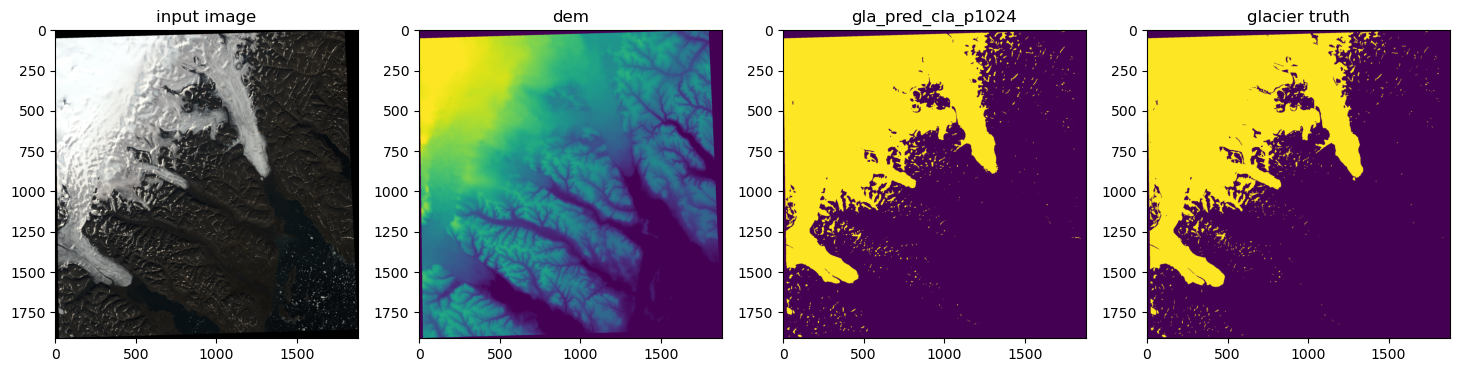

In [8]:
### show the results
imsShow([scene_dem_arr, scene_dem_arr[:,:,-1], gla_pred_cla, truth_arr], clip_list=[2, 2, 0, 0], 
        img_name_list = ['input image', 'dem', 'gla_pred_cla_p'+str(patch_size), 'glacier truth'],
         figsize=(18, 4))


### write out prediction map

In [9]:
# # ### write the result to path
# path_gla_pred_cla = config.dir_result + scene_id + '_pred_cla.tif'   ## path to save result
# with rio.open(path_gla_pred_cla, 'w', **profile_truth) as dst:
#     dst.write(gla_pred_cla[:,:,0], 1)  # write to the first band


In [10]:
# ## load and show the image and the prediction map
# with rio.open(path_scene) as img_src, rio.open(path_gla_pred_cla) as pred_src, rio.open(path_dem) as dem_src:
#         scene_arr = img_src.read().transpose(1, 2, 0)  # change to channel last format
#         dem_arr = dem_src.read(1)
#         pred_arr = pred_src.read(1)   # read the first band (the classification result)
# imsShow([scene_arr, dem_arr, pred_arr], 
#         ['input image', 'dem', 'glacier prediction'], 
#         clip_list=[2, 2, 2], 
#         figsize=(10, 3))

